In [50]:
import csv
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.patches as patches

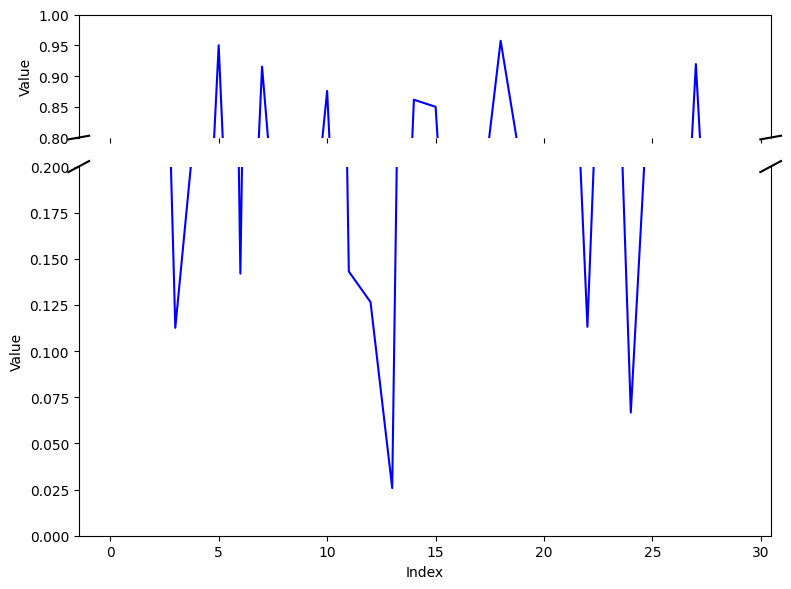

In [37]:

# Generating example data
x = np.arange(30)
y = np.random.rand(30)
y[5] = 0.95  # Introducing a large value to create the break
y[15] = 0.85  # Another large value for the break

# Creating a figure with two subplots (broken axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 3]})

# Plotting data in both subplots
ax1.plot(x, y, color='b')
ax2.plot(x, y, color='b')

# Setting y-axis limits to create the break
ax1.set_ylim(0.8, 1.0)  # Upper range for outliers
ax2.set_ylim(0, 0.2)    # Lower range for main data

# Hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Adding diagonal lines to indicate the break in the y-axis
d = .015  # Size of diagonal line in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal line
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal line

kwargs.update(transform=ax2.transAxes)  # Apply to the bottom subplot
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal line
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal line

# Labeling the x-axis and setting titles
ax2.set_xlabel("Index")
ax1.set_ylabel("Value")
ax2.set_ylabel("Value")

plt.tight_layout()
plt.show()


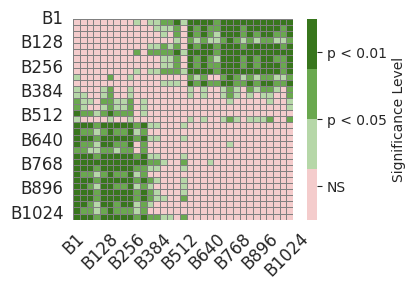

In [164]:

from scipy.stats import mannwhitneyu
import matplotlib.colors as mcolors


fuzzers = ['afl', 'aflfast', 'aflplusplus', 'ecofuzz', 'fairfuzz', 
           'honggfuzz', 'lafintel', 'memlock-heap', 'memlock-stack', 'mopt', 'redqueen', 'tortoise-bb', 'tortoise-loop']

# fuzzers = ['mopt']

# cmap = mcolors.ListedColormap(['lightgray', 'lightcoral', 'salmon', 'darkred'])
# cmap = mcolors.LinearSegmentedColormap.from_list("gray_to_white", ["white", "#4d4d4d"])
cmap = mcolors.ListedColormap(['#f4cccc', '#b6d7a8', '#6aa84f', '#38761d'])



def significance_label(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return "p < 0.01"
    elif p < 0.05:
        return "p < 0.05"
    else:
        return "NS"

for fuzzer in fuzzers:
    file_path = f'./reports/csvs/LOCATION/20241013/metrics/{fuzzer}.csv'
    data = pd.read_csv(file_path)
    
    programs = data['program'].unique()

    p_values_program_matrix = pd.DataFrame(np.ones((len(programs), len(programs))), index=programs, columns=programs)

    # Perform the Mann-Whitney U test between each pair of programs for the fuzzer 'ecofuzz'
    for i, program1 in enumerate(programs):
        for j, program2 in enumerate(programs):
            if i < j:  # Perform test only for upper triangle of matrix
                # Get duration data for both programs
                program1_data = data[(data['fuzzer'] == fuzzer) & (data['program'] == program1)]['duration']
                program2_data = data[(data['fuzzer'] == fuzzer) & (data['program'] == program2)]['duration']

                # Perform Mann-Whitney U test if both programs have data
                if not program1_data.empty and not program2_data.empty:
                    _, p_value = mannwhitneyu(program1_data, program2_data, alternative='two-sided')
                    # Update p-values matrix
                    p_values_program_matrix.loc[program1, program2] = p_value
                    p_values_program_matrix.loc[program2, program1] = p_value 

    # Apply significance labels to the matrix
    significance_program_matrix = p_values_program_matrix.applymap(significance_label)
    # significance_program_matrix

    data['B'] = data['program'].str.extract(r'B(\d+)$').astype(int)
    sorted_programs = data[['program', 'B']].drop_duplicates().sort_values('B')['program']

    # Update the significance matrix to the sorted order and rename programs to just 'B{value}'
    sorted_significance_matrix = significance_program_matrix.reindex(index=sorted_programs, columns=sorted_programs)
    sorted_significance_matrix.index = sorted_significance_matrix.columns = [f'B{num}' for num in sorted_programs.str.extract(r'B(\d+)$')[0]]

    # Map significance levels to numerical values again for the heatmap
    sorted_significance_numerical = sorted_significance_matrix.replace({
        "NS": 0, 
        "p < 0.05": 1, 
        "p < 0.01": 2, 
        "p < 0.001": 3
    })

    # Plot the heatmap
    plt.figure(figsize=(4.2, 3))
    # sns.heatmap(sorted_significance_numerical, annot=False, fmt='', cmap=cmap,
    #             cbar_kws={'ticks': [0.5, 1.5, 2.5, 3.5], 'format': '%s', 'label': 'Significance Level'}, 
    #             linewidths=0.5, linecolor='gray')
    sns.heatmap(sorted_significance_numerical, annot=False, fmt='', cmap=cmap, cbar=False, 
                linewidths=0.5, linecolor='gray')

    # Add color bar labels
    cbar_labels = ["NS", "p < 0.05", "p < 0.01"]
    cbar = plt.gca().collections[0].colorbar
    cbar.set_ticks([0.5, 1.5, 2.5])
    cbar.set_ticklabels(cbar_labels)
    
    # Display limited ticks as per previous instructions
    tick_positions = range(0, len(sorted_significance_numerical), max(1, len(sorted_significance_numerical) // 8))
    tick_labels = [sorted_significance_numerical.index[i] for i in tick_positions]

    # Add labels and title
    plt.title(f"")
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45, fontsize=12)
    plt.yticks(ticks=tick_positions, labels=tick_labels, rotation=0, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'./reports/utest/{fuzzer}.pdf', format='pdf',dpi=300)
    plt.show()


In [2]:
from scipy.stats import spearmanr

data = pd.read_csv('./reports/merged/PROB_20241028_merged_updated.csv')
df = data[data['W'] < 9]
# df = df[~df['fuzzer'].isin(["angora", "libfuzzer"])]

grouped = df.groupby(['fuzzer', 'W'])

fuzzers = df['fuzzer'].unique()

correlation_results = {}

for fuzzer in fuzzers:
    fuzzer_data = df[df['fuzzer'] == fuzzer]
    
    W_values = []
    duration_values = []

    for W, durations in fuzzer_data.groupby('W')['duration']:
        W_values.extend([W] * len(durations)) 
        duration_values.extend(durations)

    correlation, p_value = spearmanr(W_values, duration_values)
    
    correlation_results[fuzzer] = {'spearman_correlation': correlation, 'p_value': p_value}

headers = ["Fuzzer", "Correlation", "P-value"]
values = []

for fuzzer, result in correlation_results.items():
    values.append((fuzzer, result['spearman_correlation'], result['p_value']))
    print(f"Fuzzer: {fuzzer}")
    print(f"Spearman Correlation: {result['spearman_correlation']}")
    print(f"P-value: {result['p_value']}\n")

with open('./reports/correlation/PROB.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)
    writer.writerows(values)



Fuzzer: tortoise-loop
Spearman Correlation: -0.4095161918259541
P-value: 5.056966528660859e-07

Fuzzer: honggfuzz
Spearman Correlation: -0.09298588101969567
P-value: 0.27451273093433565

Fuzzer: redqueen
Spearman Correlation: -0.4515967928409119
P-value: 2.1397517528523782e-08

Fuzzer: afl
Spearman Correlation: -0.31533312274110414
P-value: 0.00014769816062678488

Fuzzer: mopt
Spearman Correlation: -0.1918382753750227
P-value: 0.023168587716876077

Fuzzer: ecofuzz
Spearman Correlation: -0.23717082451262844
P-value: 0.004780618590147813

Fuzzer: fairfuzz
Spearman Correlation: -0.3641473607128627
P-value: 9.740928712858048e-06

Fuzzer: memlock-stack
Spearman Correlation: -0.22849181255213794
P-value: 0.006620960565256439

Fuzzer: memlock-heap
Spearman Correlation: 0.06134063256576928
P-value: 0.471547497104123

Fuzzer: aflplusplus
Spearman Correlation: -0.5071732233629577
P-value: 1.6094574424656708e-10

Fuzzer: lafintel
Spearman Correlation: -0.29096096793745574
P-value: 0.0004873757177

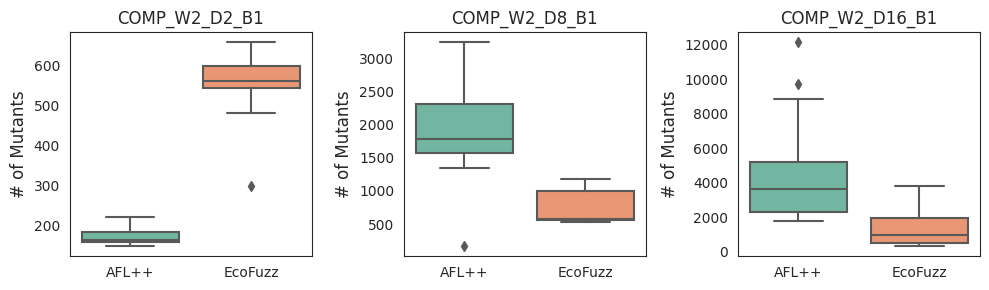

In [7]:
data = pd.read_csv('./reports-dev/csvs/COMP_0902/ecofuzz copy.csv')

filtered_data1 = data[data['program'] == "COMP_W2_D2_B2"]
filtered_data2 = data[data['program'] == "COMP_W2_D8_B2"]
filtered_data3 = data[data['program'] == "COMP_W2_D16_B2"]
sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [3.3, 3.3, 3.3]})

# sns.boxplot(x='fuzzer', y='execs', data=filtered_data1, palette=palette, ax=ax1)

palette = sns.color_palette("Set2")

# Plot each filtered dataset in its own subplot
sns.boxplot(x='fuzzer', y='execs', data=filtered_data1, palette=palette, ax=ax1)
ax1.tick_params(axis='x', rotation=0, labelsize=10)
ax1.set_ylabel('# of Mutants', fontsize=12)
ax1.set_xlabel('', fontsize=12)
ax1.set_title('COMP_W2_D2_w2_B1')

sns.boxplot(x='fuzzer', y='execs', data=filtered_data2, palette=palette, ax=ax2)
ax2.tick_params(axis='x', rotation=0, labelsize=10)
ax2.set_ylabel('# of Mutants', fontsize=12)
ax2.set_xlabel('', fontsize=12)
ax2.set_title('COMP_W2_D8_w2_B1')

sns.boxplot(x='fuzzer', y='execs', data=filtered_data3, palette=palette, ax=ax3)
ax3.tick_params(axis='x', rotation=0, labelsize=10)
ax3.set_ylabel('# of Mutants', fontsize=12)
ax3.set_xlabel('', fontsize=12)
ax3.set_title('COMP_W2_D16_w2_B1')

plt.tight_layout()
plt.savefig(f'./reports/paper/motivation.pdf', format='pdf',dpi=300)


/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/4222569624.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuzzer', y='duration', data=filtered_data1, palette=palette, ax=ax1)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/4222569624.py:14: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x='fuzzer', y='duration', data=filtered_data1, palette=palette, ax=ax1)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/4222569624.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuzzer', y='duration', data=filtered_data2, palette=palette, ax=ax2)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5

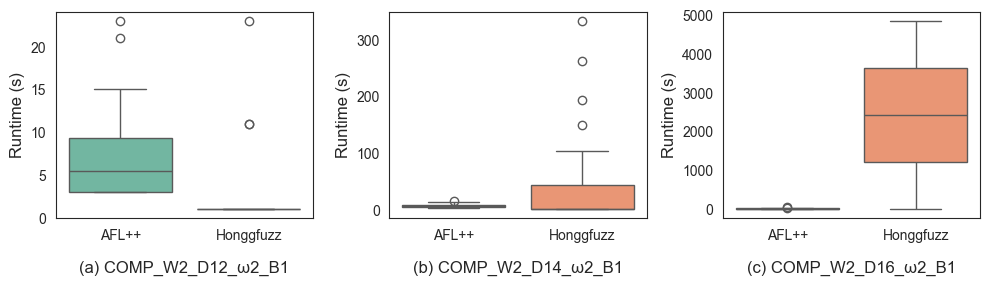

In [45]:
data = pd.read_csv('./reports/paper/motivation.csv')

filtered_data1 = data[data['program'] == "COMP_W2_D12_B2"]
filtered_data2 = data[data['program'] == "COMP_W2_D14_B2"]
filtered_data3 = data[data['program'] == "COMP_W2_D16_B2"]
sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [5, 5, 5]})

# sns.boxplot(x='fuzzer', y='execs', data=filtered_data1, palette=palette, ax=ax1)

palette = sns.color_palette("Set2")

# Plot each filtered dataset in its own subplot
sns.boxplot(x='fuzzer', y='duration', data=filtered_data1, palette=palette, ax=ax1)
ax1.tick_params(axis='x', rotation=0, labelsize=10)
ax1.set_ylabel('Runtime (s)', fontsize=12)
ax1.set_xlabel('', fontsize=12)
# ax1.set_title('COMP_W2_D12_ω2_B1')

sns.boxplot(x='fuzzer', y='duration', data=filtered_data2, palette=palette, ax=ax2)
ax2.tick_params(axis='x', rotation=0, labelsize=10)
ax2.set_ylabel('Runtime (s)', fontsize=12)
ax2.set_xlabel('', fontsize=12)
# ax2.set_title('COMP_W2_D14_ω2_B1')

sns.boxplot(x='fuzzer', y='duration', data=filtered_data3, palette=palette, ax=ax3)
ax3.tick_params(axis='x', rotation=0, labelsize=10)
ax3.set_ylabel('Runtime (s)', fontsize=12)
ax3.set_xlabel('', fontsize=12)
# ax3.set_title('COMP_W2_D16_ω2_B1')

ax1.text(0.5, -0.2, "(a) COMP_W2_D12_ω2_B1", ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax2.text(0.5, -0.2, "(b) COMP_W2_D14_ω2_B1", ha='center', va='top', transform=ax2.transAxes, fontsize=12)
ax3.text(0.5, -0.2, "(c) COMP_W2_D16_ω2_B1", ha='center', va='top', transform=ax3.transAxes, fontsize=12)


plt.tight_layout()
plt.savefig(f'./reports/paper/motivation-new.pdf', format='pdf',dpi=300)


In [48]:
# Load data
data = pd.read_csv('./reports/paper/motivation.csv')

# Filter data
filtered_data1 = data[data['program'] == "COMP_W2_D12_B2"]
filtered_data2 = data[data['program'] == "COMP_W2_D14_B2"]
filtered_data3 = data[data['program'] == "COMP_W2_D16_B2"]

# Set style
sns.set_style("white")
palette = sns.color_palette("Set2")

# Create and save individual plots
figures = [
    (filtered_data1, "(a) COMP_W2_D12_ω2_B1", "motivation_12.pdf"),
    (filtered_data2, "(b) COMP_W2_D14_ω2_B1", "motivation_14.pdf"),
    (filtered_data3, "(c) COMP_W2_D16_ω2_B1", "motivation_16.pdf")
]

for filtered_data, title, filename in figures:
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(x='fuzzer', y='duration', data=filtered_data, palette=palette)
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.set_ylabel('Runtime (s)', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    # ax.text(0.5, -0.2, title, ha='center', va='top', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'./reports/paper/{filename}', format='pdf', dpi=300)


/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/1508366438.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fuzzer', y='duration', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/1508366438.py:22: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(x='fuzzer', y='duration', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/1508366438.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fuzzer', y='duration', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T

/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/975594605.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fuzzer', y='edges_covered', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/975594605.py:22: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(x='fuzzer', y='edges_covered', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/975594605.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='fuzzer', y='edges_covered', data=filtered_data, palette=palette)
/var/folders/kr/jxlsvs2n3vj4gz_m98q5

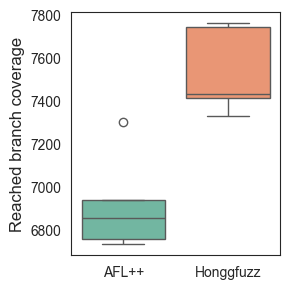

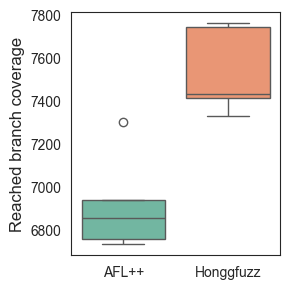

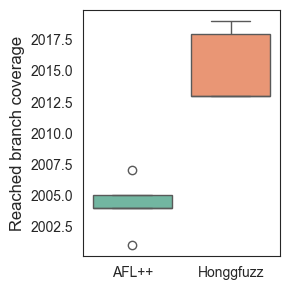

In [58]:
# Load data
data = pd.read_csv('./reports/paper/fuzzbench.csv')

# Filter data
filtered_data1 = data[data['program'] == "bloaty_fuzz_target"]
filtered_data2 = data[data['program'] == "proj4_proj_crs_to_crs_fuzzer"]
filtered_data3 = data[data['program'] == "libpng_libpng_read_fuzzer"]

# Set style
sns.set_style("white")
palette = sns.color_palette("Set2")

# Create and save individual plots
figures = [
    (filtered_data1, "bloaty_fuzz_target", "bloaty_fuzz_target.pdf"),
    (filtered_data2, "proj4_proj_crs_to_crs_fuzzer", "proj4_proj_crs_to_crs_fuzzer.pdf"),
    (filtered_data3, "libpng_libpng_read_fuzzer", "libpng_libpng_read_fuzzer.pdf")
]

for filtered_data, title, filename in figures:
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(x='fuzzer', y='edges_covered', data=filtered_data, palette=palette)
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.set_ylabel('Reached branch coverage', fontsize=12)
    ax.set_xlabel('', fontsize=12)
    # ax.text(0.5, -0.2, title, ha='center', va='top', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'./reports/paper/{filename}', format='pdf', dpi=300)


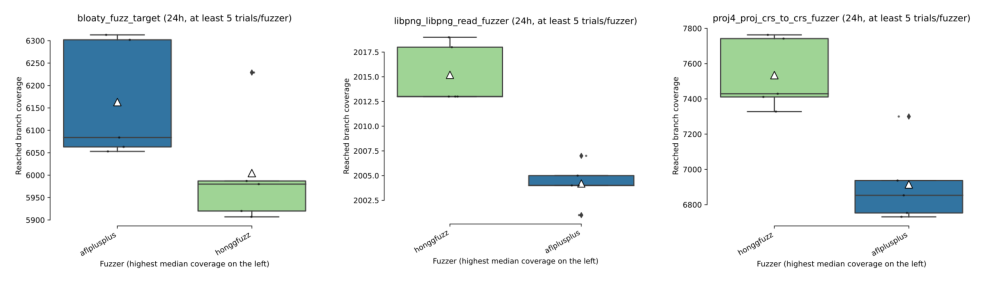

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import io
import cairosvg

# List of SVG files
svg_files = ["bloaty_fuzz_target_boxplot.svg", 
            #  "lcms_cms_transform_fuzzer_boxplot.svg", 
             "libpng_libpng_read_fuzzer_boxplot.svg",
             "proj4_proj_crs_to_crs_fuzzer_boxplot.svg"]

# Convert each SVG to PNG and store in memory
png_images = []
for svg_file in svg_files:
    png_data = cairosvg.svg2png(url=svg_file)
    img = Image.open(io.BytesIO(png_data))
    png_images.append(img)

# Create a Matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios': [5, 5, 5]})

# Plot each PNG image
for ax, img in zip(axes, png_images):
    ax.imshow(img)
    ax.axis("off")  # Hide axes

# Display the figure
plt.tight_layout()
plt.savefig("motivation-1.pdf", format="pdf", dpi=300)

In [ ]:
# data = pd.read_csv('./reports-dev/csvs/COMP_0902/ecofuzz copy.csv') # motivation
data = pd.read_csv('./reports/LOOP_20241019_merged.csv')

programs = data['program'].unique()
sns.set_style("darkgrid")
palette = sns.color_palette("Set2")

for program in programs:
    print(f'Creating boxplot for {program}')
    # plt.figure(figsize=(3, 4))
    plt.figure(figsize=(10, 12))
    program_data = data[data['program'] == program]
    sns.boxplot(x='fuzzer', y='duration', data=program_data, palette=palette)
    plt.title(program)
    plt.ylabel('Execs', fontsize=12)
    plt.xlabel('Fuzzer', fontsize=12)
    # plt.xticks(fontsize=10)
    plt.xticks(rotation=45,fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.grid(True, color='white', linestyle='-', linewidth=0.75)
    
    plt.tight_layout()
    
    os.makedirs('./reports/figures/loop_1019', exist_ok=True)
    plt.savefig(f'./reports/figures/loop_1019/{program}_time.pdf', format='pdf',dpi=300)


In [5]:
# Merge multiple CSV files into one
def merge_csv():
    csv_files = glob.glob(os.path.join('./reports/csvs/PROB-TEST/20241028/metrics', '*.csv'))
    data_set = []

    for idx, f in enumerate(csv_files):
        with open(f, 'r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            
            if idx == 0:
                headers = next(reader)  # Skip header row
                data_set.extend(list(reader))
            else:
                next(reader)  # Skip header row
                data_set.extend(list(reader))

    with open('./reports/PROB_20241028_merged.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
        writer.writerows(data_set)

    print("CSV files have been merged successfully.")

merge_csv()


CSV files have been merged successfully.


In [6]:
# Update the CSV file by extracting 'W' and 'D' values from the 'program' column
def update_csv():
    df = pd.read_csv('./reports/PROB_20241028_merged.csv')
    # df['C'] = df['program'].str.extract(r'C(\d+)_').astype(int)
    df['W'] = df['program'].str.extract(r'W(\d+)').astype(int)
    # df['D'] = df['program'].str.extract(r'D(\d+)').astype(int)
    # df['B'] = df['program'].str.extract(r'B(\d+)').astype(int)
    # df['L'] = df['program'].str.extract(r'L(\d+)').astype(int)
    # df['I'] = df['program'].str.extract(r'I(\d+)').astype(int)
    
    df.to_csv('./reports/merged/PROB_20241028_merged_updated.csv', index=False)

# Run the update_csv function
update_csv()


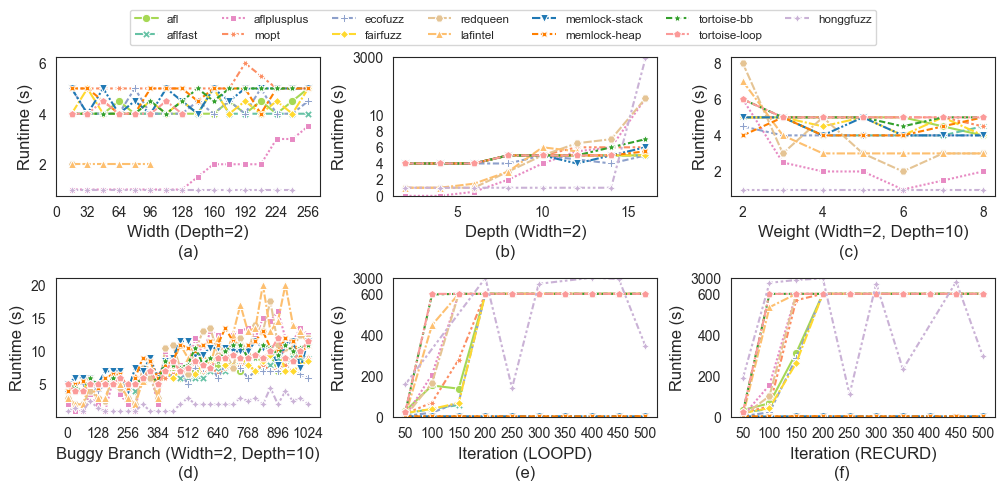

In [51]:

color_mapping = {
    'afl': '#a6d854',            # Light Green
    'aflfast': '#66c2a5',        # Teal
    'aflplusplus': '#e78ac3',    # Pink
    'mopt': '#fc8d62',           # Coral
    'ecofuzz': '#8da0cb',        # Light Blue
    'fairfuzz': '#ffd92f',       # Yellow
    'redqueen': '#e5c494',       # Beige
    'lafintel': '#fdbf6f',       # Light Orange
    'memlock-stack': '#1f78b4',  # Dark Blue
    'memlock-heap': '#ff7f00',   # Orange
    'tortoise-bb': '#33a02c',    # Dark Green
    'tortoise-loop': '#fb9a99',  # Light Red
    'honggfuzz': '#cab2d6',      # Lavender
    # 'libfuzzer': '#b3b3b3',      # Gray
}

hue_order1 = [
    'afl',
    'aflfast',
    'aflplusplus', 
    'mopt',
    'ecofuzz',
    'fairfuzz',
    'redqueen',
    'lafintel',
    'memlock-stack',
    'memlock-heap',
    'tortoise-bb',
    'tortoise-loop',
    'honggfuzz'
    # 'libfuzzer',
]

filtered_data = pd.read_csv('./reports/merged/COMPW_20241017_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.set_style("white")
fig, ((ax1, ax3, ax4), (ax2, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 4.5))
# ax4 = ax3.twinx()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

ax1.set_yscale('linear')

plt.title("")
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
ax1.set_ylabel('Runtime (s)', fontsize=12)
ax1.set_xlabel('Width (Depth=2)', fontsize=12)
ax1.set_xticks(range(0, 257, 32))
ax1.get_legend().remove()
fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=7, fontsize='small')


filtered_data3 = pd.read_csv('./reports/merged/COMPD_20241012_merged_updated.csv')
filtered_data3 = filtered_data3[filtered_data3['fuzzer'].isin(hue_order1)]

median_data3 = filtered_data3.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data3, palette=color_mapping, 
             errorbar='sd', markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_yscale('symlog', linthresh=12, linscale=5)
ax3.set_ylim(0, 3000)
ax3.set_yticks([0, 2, 4, 6, 8, 10, 3000])
ax3.yaxis.set_major_formatter(plt.ScalarFormatter()) 
# ax4.set_yscale('log')

plt.title("")
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
ax3.set_ylabel('Runtime (s)', fontsize=12)
# ax4.set_ylabel('', fontsize=12)
ax3.set_xlabel('Depth (Width=2)', fontsize=12)

ax1.text(0.5, -0.35, "(a)", ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax3.text(1.7, -0.35, "(b)", ha='center', va='top', transform=ax1.transAxes, fontsize=12)
# ax3.text(7, 0.3, "honggfuzz uses Log Scale", fontsize=10, color='purple')


filtered_data2 = pd.read_csv('./reports/merged/LOCATION_20241013_merged_updated.csv')
filtered_data2 = filtered_data2[filtered_data2['fuzzer'].isin(hue_order1)]
   
median_data2 = filtered_data2.groupby(['fuzzer', 'B'], as_index=False)['duration'].median()

# sns.set_style("white")
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x='B', y='duration', hue='fuzzer', 
             data=median_data2, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax2, legend=False)

ax2.set_ylabel('Runtime (s)', fontsize=12)
ax2.set_xlabel('Buggy Branch (Width=2, Depth=10)', fontsize=12)
ax2.set_xticks(range(0, 1025, 128))
# ax1.get_legend().remove()
# fig.legend(handles=ax2.get_legend_handles_labels()[0], 
#            labels=ax2.get_legend_handles_labels()[1], 
#            loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=7, fontsize='small')


filtered_data4 = pd.read_csv('./reports/merged/PROB_20241028_merged_updated.csv')
filtered_data4 = filtered_data4[filtered_data4['W'] < 9]
filtered_data4 = filtered_data4[filtered_data4['fuzzer'].isin(hue_order1)]

median4 = filtered_data4.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median4, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax4, legend=False)

ax4.set_ylabel('Runtime (s)', fontsize=12)
# ax4.set_xscale('log')
ax4.set_xlabel('Weight (Width=2, Depth=10)', fontsize=12)

ax2.text(0.5, -0.35, "(d)", ha='center', va='top', transform=ax2.transAxes, fontsize=12)
ax4.text(3.0, -0.35, "(c)", ha='center', va='top', transform=ax1.transAxes, fontsize=12)


filtered_data5 = pd.read_csv('./reports/merged/LOOPD_20241019_merged_updated.csv')
filtered_data5 = filtered_data5[filtered_data5['fuzzer'].isin(hue_order1)]
   
median_data5 = filtered_data5.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax5, legend=False)

ax5.set_yscale('symlog', linthresh=600, linscale=5)
ax5.set_ylim(0, 3000)
ax5.set_yticks([0, 200, 400, 600, 3000])
ax5.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax5.set_ylabel('Runtime (s)', fontsize=12)
ax5.set_xlabel('Iteration (LOOPD)', fontsize=12)
ax5.set_xticks(range(50, 501, 50))

filtered_data6 = pd.read_csv('./reports/merged/RECURD_20241023_merged_updated.csv')
filtered_data6 = filtered_data6[filtered_data6['fuzzer'].isin(hue_order1)]

median_data6 = filtered_data6.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax6, legend=False)

ax6.set_yscale('symlog', linthresh=600, linscale=5)
ax6.set_ylim(0, 3000)
ax6.set_yticks([0, 200, 400, 600, 3000])
ax6.yaxis.set_major_formatter(plt.ScalarFormatter()) 

plt.title("")
ax6.set_ylabel('Runtime (s)', fontsize=12)
ax6.set_xlabel('Iteration (RECURD)', fontsize=12)
ax6.set_xticks(range(50, 501, 50))

ax5.text(0.5, -0.35, "(e)", ha='center', va='top', transform=ax5.transAxes, fontsize=12)
ax6.text(1.7, -0.35, "(f)", ha='center', va='top', transform=ax5.transAxes, fontsize=12)

plt.tight_layout(pad=0.5)
plt.savefig('./reports/paper/control-flow.pdf', format='pdf', bbox_inches='tight', dpi=300)



/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/2940786583.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


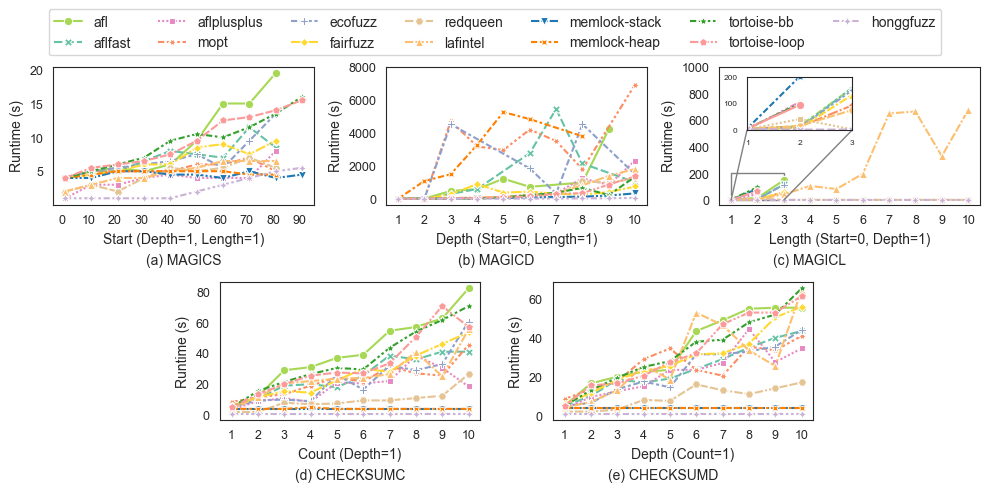

In [53]:
hue_order1 = [
    'afl',
    'aflfast',
    'aflplusplus', 
    'mopt',
    'ecofuzz',
    'fairfuzz',
    'redqueen',
    'lafintel',
    'memlock-stack',
    'memlock-heap',
    'tortoise-bb',
    'tortoise-loop',
    'honggfuzz'
    # 'libfuzzer',
]

sns.set_style("white")
fig = plt.figure(figsize=(10, 4.5))

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((2, 6), (0, 4), colspan=2)

ax4 = plt.subplot2grid((2, 6), (1, 1), colspan=2)
ax5 = plt.subplot2grid((2, 6), (1, 3), colspan=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5) 

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax3.tick_params(labelsize=9)
ax4.tick_params(labelsize=9)
ax5.tick_params(labelsize=9)

filtered_data = pd.read_csv('./reports/merged/MAGICS_20241014_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
filtered_data1 = filtered_data1[filtered_data1['S'] <= 91]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'S'], as_index=False)['duration'].median()


sns.lineplot(x='S', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

ax1.set_ylabel('Runtime (s)', fontsize=10)
ax1.set_xlabel('Start (Depth=1, Length=1)', fontsize=10)
ax1.set_xticks(range(0, 91, 10))
ax1.get_legend().remove()

fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=7, fontsize=10)

filtered_data2 = pd.read_csv('./reports/merged/MAGICD_20241025_merged_updated.csv')
filtered_data2 = filtered_data2[filtered_data2['fuzzer'].isin(hue_order1)]
filtered_data2 = filtered_data2[filtered_data2['D'] <= 10]

median_data2 = filtered_data2.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data2, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax2, legend=False)

ax2.set_ylabel('Runtime (s)', fontsize=10)
ax2.set_xlabel('Depth (Start=0, Length=1)', fontsize=10)
ax2.set_xticks(range(1, 11, 1))
ax2.set_yticks(range(0, 8001, 2000))

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

filtered_data3 = pd.read_csv('./reports/merged/MAGICL_20241018_merged_updated.csv')
filtered_data3 = filtered_data3[filtered_data3['fuzzer'].isin(hue_order1)]

median_data3 = filtered_data3.groupby(['fuzzer', 'L'], as_index=False)['duration'].median()

sns.lineplot(x='L', y='duration', hue='fuzzer', 
             data=median_data3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_xticks(range(1, 11, 1))
ax3.set_yticks(range(0, 1001, 200))

ax3.set_ylabel('Runtime (s)', fontsize=10)
ax3.set_xlabel('Length (Start=0, Depth=1)', fontsize=10)

zoom_ax = zoomed_inset_axes(ax3, zoom=2, loc="upper left", 
                            bbox_to_anchor=(0.08, 0.98), 
                            bbox_transform=ax3.transAxes)
sns.lineplot(x='L', y='duration', hue='fuzzer', 
             data=filtered_data3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax, legend=False)

zoom_ax.set_ylabel('', fontsize=10)
zoom_ax.set_xlabel('', fontsize=10)

zoom_ax.set_xlim(1, 3)
zoom_ax.set_ylim(0, 200)

zoom_ax.set_xticks([1, 2, 3])
zoom_ax.tick_params(labelsize=6)

mark_inset(ax3, zoom_ax, loc1=3, loc2=4, fc="none", ec="0.5")

ax1.text(0.5, -0.35, "(a) MAGICS", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax2.text(1.7, -0.35, "(b) MAGICD", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax3.text(2.9, -0.35, "(c) MAGICL", ha='center', va='top', transform=ax1.transAxes, fontsize=10)

filtered_data4 = pd.read_csv('./reports/merged/HARD_20241023_merged_updated.csv')
filtered_data4 = filtered_data4[filtered_data4['fuzzer'].isin(hue_order1)]
filtered_data5 = filtered_data4[filtered_data4['D'] == 1]
filtered_data6 = filtered_data4[filtered_data4['C'] == 1]
   
median_data5 = filtered_data5.groupby(['fuzzer', 'C'], as_index=False)['duration'].median()
median_data6 = filtered_data6.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='C', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax4, legend=False)

ax4.set_ylabel('Runtime (s)', fontsize=10)
ax4.set_xlabel('Count (Depth=1)', fontsize=10)
ax4.set_xticks(range(1, 11, 1))

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax5, legend=False)

ax5.set_ylabel('Runtime (s)', fontsize=10)
ax5.set_xticks(range(1, 11, 1))
ax5.set_xlabel('Depth (Count=1)', fontsize=10)

ax4.text(0.5, -0.35, "(d) CHECKSUMC", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax5.text(1.7, -0.35, "(e) CHECKSUMD", ha='center', va='top', transform=ax4.transAxes, fontsize=10)

plt.tight_layout()
plt.savefig('./reports/paper/data-flow.pdf', format='pdf', bbox_inches='tight', dpi=300)


/var/folders/kr/jxlsvs2n3vj4gz_m98q5pbz40000gn/T/ipykernel_1487/2803417802.py:233: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


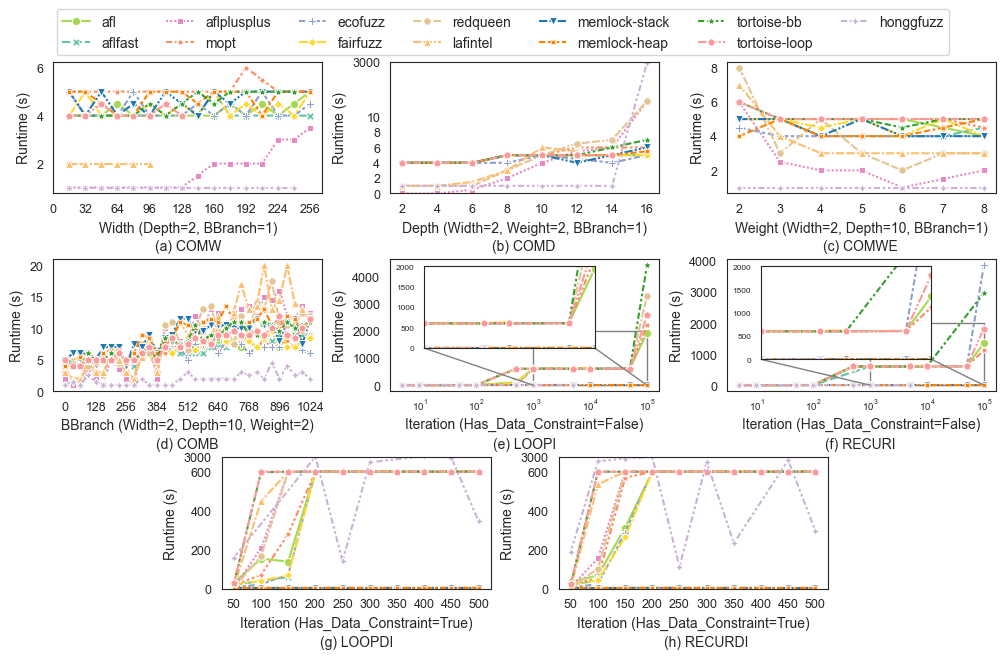

In [54]:
hue_order1 = [
    'afl',
    'aflfast',
    'aflplusplus', 
    'mopt',
    'ecofuzz',
    'fairfuzz',
    'redqueen',
    'lafintel',
    'memlock-stack',
    'memlock-heap',
    'tortoise-bb',
    'tortoise-loop',
    'honggfuzz'
    # 'libfuzzer',
]

sns.set_style("white")
fig = plt.figure(figsize=(10, 6))

ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 6), (0, 2), colspan=2)
ax3 = plt.subplot2grid((3, 6), (0, 4), colspan=2)

ax4 = plt.subplot2grid((3, 6), (1, 0), colspan=2)
ax5 = plt.subplot2grid((3, 6), (1, 2), colspan=2)
ax6 = plt.subplot2grid((3, 6), (1, 4), colspan=2)

ax7 = plt.subplot2grid((3, 6), (2, 1), colspan=2)
ax8 = plt.subplot2grid((3, 6), (2, 3), colspan=2)

plt.subplots_adjust(wspace=0.5, hspace=0.5) 

ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)
ax3.tick_params(labelsize=9)
ax4.tick_params(labelsize=9)
ax5.tick_params(labelsize=9)
ax6.tick_params(labelsize=9)
ax7.tick_params(labelsize=9)
ax8.tick_params(labelsize=9)

filtered_data = pd.read_csv('./reports/merged/COMPW_20241017_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

ax1.set_ylabel('Runtime (s)', fontsize=10)
ax1.set_xlabel('Width (Depth=2, BBranch=1)', fontsize=10)
ax1.set_xticks(range(0, 257, 32))
ax1.get_legend().remove()

fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=7, fontsize=10)

filtered_data2 = pd.read_csv('./reports/merged/COMPD_20241012_merged_updated.csv')
filtered_data2 = filtered_data2[filtered_data2['fuzzer'].isin(hue_order1)]

median_data2 = filtered_data2.groupby(['fuzzer', 'D'], as_index=False)['duration'].median()

sns.lineplot(x='D', y='duration', hue='fuzzer', 
             data=median_data2, palette=color_mapping, 
             errorbar='sd', markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax2, legend=False)

ax2.set_yscale('symlog', linthresh=12, linscale=5)
ax2.set_ylim(0, 3000)
ax2.set_yticks([0, 2, 4, 6, 8, 10, 3000])
ax2.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax2.set_xlabel('Depth (Width=2, Weight=2, BBranch=1)', fontsize=10)
ax2.set_ylabel('Runtime (s)', fontsize=10)
ax2.set_xticks(range(2, 17, 2))

filtered_data3 = pd.read_csv('./reports/merged/PROB_20241028_merged_updated.csv')
filtered_data3 = filtered_data3[filtered_data3['W'] < 9]
filtered_data3 = filtered_data3[filtered_data3['fuzzer'].isin(hue_order1)]

median3 = filtered_data3.groupby(['fuzzer', 'W'], as_index=False)['duration'].median()

sns.lineplot(x='W', y='duration', hue='fuzzer', 
             data=median3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_ylabel('Runtime (s)', fontsize=10)
ax3.set_xlabel('Weight (Width=2, Depth=10, BBranch=1)', fontsize=10)

filtered_data4 = pd.read_csv('./reports/merged/LOCATION_20241013_merged_updated.csv')
filtered_data4 = filtered_data4[filtered_data4['fuzzer'].isin(hue_order1)]
   
median_data4 = filtered_data4.groupby(['fuzzer', 'B'], as_index=False)['duration'].median()

sns.lineplot(x='B', y='duration', hue='fuzzer', 
             data=median_data4, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax4, legend=False)

ax4.set_ylabel('Runtime (s)', fontsize=10)
ax4.set_xlabel('BBranch (Width=2, Depth=10, Weight=2)', fontsize=10)
ax4.set_xticks(range(0, 1025, 128))
ax4.set_yticks([0, 5, 10, 15, 20])

filtered_data5 = pd.read_csv('./reports/merged/LOOP_20241019_merged_updated.csv')
filtered_data5 = filtered_data5[filtered_data5['fuzzer'].isin(hue_order1)]
   
median_data5 = filtered_data5.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax5, legend=False)

ax5.set_ylabel('Runtime (s)', fontsize=10)
ax5.set_xlabel('Iteration (Has_Data_Constraint=False)', fontsize=10)
ax5.tick_params(axis="x", labelsize=7, pad=0)
ax5.set_xscale('log')

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

zoom_ax5 = zoomed_inset_axes(ax5, zoom=1.5, loc="upper left", 
                            bbox_to_anchor=(0.1, 1), 
                            bbox_transform=ax5.transAxes)
sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data5, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax5, legend=False)

zoom_ax5.set_ylabel('', fontsize=10)
zoom_ax5.set_xlabel('', fontsize=10)
zoom_ax5.set_xscale('log')

zoom_ax5.set_xlim(1000, 100000)
zoom_ax5.set_ylim(0, 2000)

# zoom_ax5.set_xticks([1, 2, 3])
zoom_ax5.tick_params(labelsize=6)
zoom_ax5.tick_params(axis="x", labelbottom=False)
# zoom_ax5.tick_params(axis="y", labelleft=False)

mark_inset(ax5, zoom_ax5, loc1=3, loc2=4, fc="none", ec="0.5")

filtered_data6 = pd.read_csv('./reports/merged/RECUR_20241019_merged_updated.csv')
filtered_data6 = filtered_data6[filtered_data6['fuzzer'].isin(hue_order1)]

median_data6 = filtered_data6.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax6, legend=False)

ax6.set_ylabel('Runtime (s)', fontsize=10)
ax6.set_xscale('log')
ax6.tick_params(axis="x", labelsize=7, pad=0)
ax6.set_xlabel('Iteration (Has_Data_Constraint=False)', fontsize=10)

zoom_ax6 = zoomed_inset_axes(ax6, zoom=1.5, loc="upper left", 
                            bbox_to_anchor=(0.1, 1), 
                            bbox_transform=ax6.transAxes)
sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data6, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=zoom_ax6, legend=False)

zoom_ax6.set_ylabel('', fontsize=10)
zoom_ax6.set_xlabel('', fontsize=10)
zoom_ax6.set_xscale('log')

zoom_ax6.set_xlim(1000, 100000)
zoom_ax6.set_ylim(0, 2000)

# zoom_ax6.set_xticks([1, 2, 3])
zoom_ax6.tick_params(labelsize=6)
zoom_ax6.tick_params(axis="x", labelbottom=False)
# zoom_ax6.tick_params(axis="y", labelleft=False)

mark_inset(ax6, zoom_ax6, loc1=3, loc2=4, fc="none", ec="0.5")

filtered_data7 = pd.read_csv('./reports/merged/LOOPD_20241019_merged_updated.csv')
filtered_data7 = filtered_data7[filtered_data7['fuzzer'].isin(hue_order1)]
   
median_data7 = filtered_data7.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data7, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax7, legend=False)

ax7.set_yscale('symlog', linthresh=600, linscale=5)
ax7.set_ylim(0, 3000)
ax7.set_yticks([0, 200, 400, 600, 3000])
ax7.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax7.set_ylabel('Runtime (s)', fontsize=10)
ax7.set_xlabel('Iteration (Has_Data_Constraint=True)', fontsize=10)
ax7.set_xticks(range(50, 501, 50))

filtered_data8 = pd.read_csv('./reports/merged/RECURD_20241023_merged_updated.csv')
filtered_data8 = filtered_data8[filtered_data8['fuzzer'].isin(hue_order1)]

median_data8 = filtered_data8.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data8, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax8, legend=False)

ax8.set_yscale('symlog', linthresh=600, linscale=5)
ax8.set_ylim(0, 3000)
ax8.set_yticks([0, 200, 400, 600, 3000])
ax8.yaxis.set_major_formatter(plt.ScalarFormatter()) 

ax8.set_ylabel('Runtime (s)', fontsize=10)
ax8.set_xlabel('Iteration (Has_Data_Constraint=True)', fontsize=10)
ax8.set_xticks(range(50, 501, 50))

ax1.text(0.5, -0.35, "(a) COMW", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax2.text(1.75, -0.35, "(b) COMD", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax3.text(3, -0.35, "(c) COMWE", ha='center', va='top', transform=ax1.transAxes, fontsize=10)
ax4.text(0.5, -0.35, "(d) COMB", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax5.text(1.75, -0.35, "(e) LOOPI", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax6.text(3, -0.35, "(f) RECURI", ha='center', va='top', transform=ax4.transAxes, fontsize=10)
ax7.text(0.5, -0.35, "(g) LOOPDI", ha='center', va='top', transform=ax7.transAxes, fontsize=10)
ax8.text(1.8, -0.35, "(h) RECURDI", ha='center', va='top', transform=ax7.transAxes, fontsize=10)

plt.tight_layout(pad=0.5)
plt.savefig('./reports/paper/control-flow-new.pdf', format='pdf', bbox_inches='tight', dpi=300)

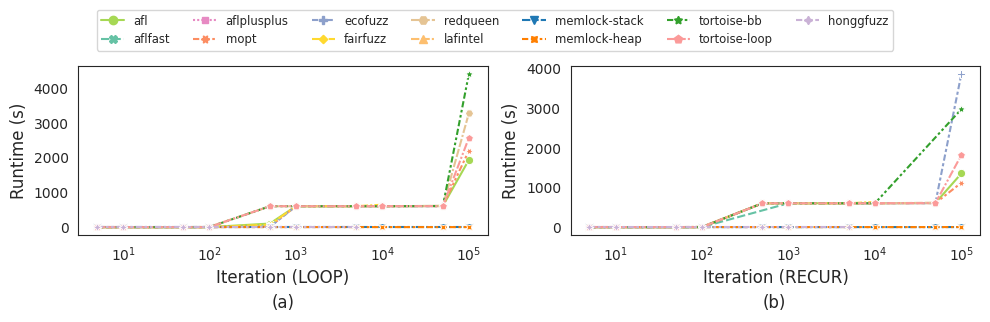

In [98]:
filtered_data = pd.read_csv('./reports/merged/LOOP_20241019_merged_updated.csv')
filtered_data1 = filtered_data[filtered_data['fuzzer'].isin(hue_order1)]
   
median_data1 = filtered_data1.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.set_style("white")
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data1, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax1)

plt.title("")
ax1.set_ylabel('Runtime (s)', fontsize=12)
ax1.set_xlabel('Iteration (LOOP)', fontsize=12)
ax1.set_xscale('log')
ax1.get_legend().remove()
fig.legend(handles=ax1.get_legend_handles_labels()[0], 
           labels=ax1.get_legend_handles_labels()[1], 
           loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=7, fontsize='small')

filtered_data_d = pd.read_csv('./reports/merged/RECUR_20241019_merged_updated.csv')
filtered_data3 = filtered_data_d[filtered_data_d['fuzzer'].isin(hue_order1)]

median_data3 = filtered_data3.groupby(['fuzzer', 'I'], as_index=False)['duration'].median()

sns.lineplot(x='I', y='duration', hue='fuzzer', 
             data=median_data3, palette=color_mapping, 
             errorbar=None, markers=True, style='fuzzer', 
             hue_order=hue_order1, ax=ax3, legend=False)

ax3.set_ylabel('Runtime (s)', fontsize=12)
ax3.set_xscale('log')
ax3.set_xlabel('Iteration (RECUR)', fontsize=12)

ax1.text(0.5, -0.35, "(a)", ha='center', va='top', transform=ax1.transAxes, fontsize=12)
ax3.text(1.7, -0.35, "(b)", ha='center', va='top', transform=ax1.transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('./reports/paper/LOOPI_RECURI.pdf', format='pdf', bbox_inches='tight', dpi=300)



In [ ]:
# Helper function to create a blank image
def create_blank_image():
    return np.ones((100, 100, 3))

# Create a grid of images from the specified directory
def create_image_grid():
    output_file='.png'
    image_files = [ 
        './reports/utest/aflplusplus.pdf',
        './reports/utest/honggfuzz.pdf',
        './reports/utest/mopt.pdf',
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 3)) 

    for idx, ax in enumerate(axes.flat):
        if idx < len(image_files):
            img = mpimg.imread(image_files[idx]) if image_files[idx] != 'NONE' else create_blank_image()
            ax.imshow(img)
            ax.axis('off') 
        else:
            ax.axis('off')

    plt.tight_layout()
    # plt.savefig(output_file) 
    plt

create_image_grid()

In [ ]:
# Generate statistical measures and save to CSV files
def statistics():
    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
    os.makedirs(f'./reports/{timestamp}', exist_ok=True)
    
    df = pd.read_csv('./reports/merged.csv')
    
    mean_execs = df.groupby(['program', 'fuzzer'])['execs'].mean().reset_index()
    pivot_table_mea = mean_execs.pivot(index='program', columns='fuzzer', values='execs')
    pivot_table_mea = pivot_table_mea.fillna('N/A')
    pivot_table_mea.to_csv(f'./reports/{timestamp}/mean_execs.csv')
    
    median_execs = df.groupby(['program', 'fuzzer'])['execs'].std().reset_index()
    pivot_table_med = median_execs.pivot(index='program', columns='fuzzer', values='execs')
    pivot_table_med = pivot_table_med.fillna('N/A')
    pivot_table_med.to_csv(f'./reports/{timestamp}/std_execs.csv')
    
    std_execs = df.groupby(['program', 'fuzzer'])['execs'].median().reset_index()
    pivot_table_std = std_execs.pivot(index='program', columns='fuzzer', values='execs')
    pivot_table_std = pivot_table_std.fillna('N/A')
    pivot_table_std.to_csv(f'./reports/{timestamp}/median_execs.csv')

statistics()


In [12]:
# Merge statistical CSV files into a single file
def merge_stat():
    fmean = './reports/20240819_131612/mean_execs.csv'
    fstd = './reports/20240819_131612/std_execs.csv'
    fmedian = './reports/20240819_131612/median_execs.csv'
    data_set1 = []
    data_set2 = []
    data_set3 = []
    with open(fmean, 'r', newline='', encoding='utf-8') as f1:
            data_set1 = list(csv.reader(f1))
    with open(fmedian, 'r', newline='', encoding='utf-8') as f2:
            data_set2 = list(csv.reader(f2))
    with open(fstd, 'r', newline='', encoding='utf-8') as f3:
            data_set3 = list(csv.reader(f3))
    with open('./reports/20240819_131612/merged.csv', 'w', newline='', encoding='UTF8') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data_set1[0])
        for i in range(1, len(data_set1)):
            writer.writerow(data_set1[i])
            writer.writerow(data_set2[i])
            writer.writerow(data_set3[i])
            writer.writerow([])
    print("CSV files have been merged successfully.")

merge_stat()


CSV files have been merged successfully.


In [ ]:
# Create heatmaps for the statistical data
def stats_heatmap():
    data = pd.read_csv('./reports/20240819_131612/mean_execs.csv', index_col=0)

    data = data.apply(pd.to_numeric, errors='coerce')

    num_rows = len(data)
    num_cols = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
    
    if num_rows == 1:
        axes = [axes]
    
    for idx, (row_name, row_data) in enumerate(data.iterrows()):
        sns.heatmap([row_data.values], annot=True, fmt=".2f", cmap='coolwarm', 
                    linewidths=0.5, linecolor='gray', cbar=False, ax=axes[idx])
        
        axes[idx].set_title(f"Heatmap for {row_name}")
        axes[idx].set_xlabel("Metrics")
        axes[idx].set_ylabel(row_name)
        
    plt.tight_layout()

    output_dir = './reports/20240819_131612/'
    os.makedirs(output_dir, exist_ok=True)
    # plt.savefig(f'{output_dir}combined_heatmap.png', dpi=300)
    # plt.close()
    plt

stats_heatmap()


In [ ]:
# Perform t-tests comparing the execs values between different fuzzers
def ttest():
    df = pd.read_csv('./reports/merged.csv')
    baseline_fuzzer = 'aflfast_fast'
    t_test_results = {}

    for program in df['program'].unique():
        program_data = df[df['program'] == program]
        baseline_data = program_data[program_data['fuzzer'] == baseline_fuzzer]['execs']
    
        for fuzzer in program_data['fuzzer'].unique():
            if fuzzer != baseline_fuzzer:
                fuzzer_data = program_data[program_data['fuzzer'] == fuzzer]['execs']
                t_stat, p_val = stats.ttest_ind(baseline_data, fuzzer_data, equal_var=False)
                t_test_results[(program, fuzzer)] = (t_stat, p_val)

    t_test_df = pd.DataFrame(t_test_results).T.reset_index()
    t_test_df.columns = ['program', 'fuzzer', 't_stat', 'p_val']
    t_test_df.to_csv('./reports/ttest.csv', index=False)

ttest()
